# Capstone Project - The Battle of Neighborhoods (Week 1)

For this week, you will required to submit the following:

*    A description of the problem and a discussion of the background. (15 marks)
*    A description of the data and how it will be used to solve the problem. (15 marks)

Clearly define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to solve or execute. Remember that data science problems always target an audience and are meant to help a group of stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about your problem.  

This submission will eventually become your Introduction/Business Problem section in your final report. So I recommend that you push the report (having your Introduction/Business Problem section only for now) to your Github repository and submit a link to it.  

## Introduction/Business Problem

I decided to start a new business opening an italian restaurant and will analyze where is the best place to between Toronto and Paris by checking other similar places around. By using the KMeans clustering algorithm I will be clustering Italian restaurants in Toronto and using the elbow method to determine the optimal number of clusters. In Paris
will also do the data wrangling setup by defining the postal codes and neighborhood names, getting center coords of each neighborhood and Paris using Nominatum.  
By checking that, we will know where do we have more Italian restaurants, population, if historic italian neighborhood and also get some details from Wikipedia to compare.


# Capstone Project - The Battle of Neighborhoods (Week 2)


In [2]:
import json
import pandas as pd
from bs4 import BeautifulSoup
import requests
try: 
    import folium
except:
    !pip install folium
    import folium
from geopy.geocoders import Nominatim
import json
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

### Define Foursquare creds

In [3]:
# The code was removed by Watson Studio for sharing.

### Define handy `ExploreNearbyVanues` function for calling Foursquare

In [4]:
# N.B. LIMIT = 50 is the default and max for search endpoints anyway

# From the API documentation, this is the categoryId for Italian Restaurants
pt_restos = '4bf58dd8d48988d110941735'

def SearchNearbyVenues(neighborhoods, lats, lons, categoryId, radius = 4000, LIMIT = 50):
    
    venues_list = []
    
    print('Getting results from:')
    for neighborhood, lat, lon in zip(neighborhoods, lats, lons):

        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon,
            categoryId,
            radius, 
            LIMIT)
            
        results = requests.get(url).json()['response']['venues']
    
        # Here neighborhood is actually a grouping of the neighborhoods within each PostalCode
        venues_list.append([(
            neighborhood, 
            lat, 
            lon, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng']) for v in results])
        
        print('%s ... ' % neighborhood, end = '')

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhoods', 
                  'Neighborhoods Lat', 
                  'Neighborhoods Lon', 
                  'Venue Name', 
                  'Venue Lat', 
                  'Venue Lon']
    
    print('DONE.')

    return(nearby_venues)

## Toronto

### Data wrangling & setup

- Scrape the web using requests to get neighborhood info
- Parse the html using BeautifulSoup
- Clean up our dataframe
- Get center coordinates of Toronto using Nominatim

In [5]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)

soup = BeautifulSoup(page.text, 'html.parser')
table = soup.find('table');

table_rows = table.find_all('tr')
l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
df = pd.DataFrame(l, columns = ['PostalCode', 'Borough', 'Neighborhood'])

df['Neighborhood'] = df['Neighborhood'].str.rstrip('\n')
df.drop(0, inplace = True)
df.sort_values(by = 'PostalCode', inplace = True)

# We'll ignore the borough info for this assignment, it's not too useful here.
# We really just want the PostalCodes. 
# The Neighborhood info is more human-readable so we'll keep that in case we need it later. 
df_grouped = df.groupby('PostalCode')['Neighborhood'].apply(', '.join).reset_index()

df_postal_code = df_grouped[['PostalCode']].copy()

!wget -q 'https://cocl.us/Geospatial_data'

df_coords = pd.read_csv('Geospatial_data')
df_coords.rename(columns = {'Postal Code': 'PostalCode'}, inplace = True)

df_withcoords = pd.merge(df_grouped, df_coords, on = 'PostalCode')

address = 'Toronto, Ontario, Canada'
geolocator = Nominatim(user_agent = 'toronto_explorer')
location = geolocator.geocode(address)
toronto_lat = location.latitude
toronto_lon = location.longitude
print('Center coordinates of Toronto are Latitude {} and Longitude {}).'.format(toronto_lat, toronto_lon))

print('Found %i postal codes / neighborhood groupings.' % df_withcoords.shape[0])
print('\nHere are the first 5 rows of our Toronto dataframe:')
df_withcoords.head()

Center coordinates of Toronto are Latitude 43.653963 and Longitude -79.387207).
Found 103 postal codes / neighborhood groupings.

Here are the first 5 rows of our Toronto dataframe:


,PostalCode,Neighborhood,Latitude,Longitude
0,M1B,"Malvern, Rouge",43.806686,-79.194353
1,M1C,"Port Union, Rouge Hill, Highland Creek",43.784535,-79.160497
2,M1E,"West Hill, Morningside, Guildwood",43.763573,-79.188711
3,M1G,Woburn,43.770992,-79.216917
4,M1H,Cedarbrae,43.773136,-79.239476


### Searching for all Italian restaurants in Toronto

- Searching each PostalCode (neighborhood grouping) with Foursquare
- Cleaning dataframe (removing duplicated)

In [6]:
pt_venues = SearchNearbyVenues(neighborhoods = df_withcoords['Neighborhood'], lats = df_withcoords['Latitude'], \
                               lons = df_withcoords['Longitude'], categoryId = pt_restos, radius = 1000, LIMIT = 50)

pt_venues.drop_duplicates('Venue Lat', keep = 'first', inplace = True)
pt_venues.drop(['Neighborhoods Lat', 'Neighborhoods Lon'], axis = 1, inplace = True)
print('\nThere are %i Italian restaurants in Toronto.' % int(pt_venues.shape[0]))
print('\nHere are the first 5 rows of our Toronto Italian restaurants dataframe:')
pt_venues.head()

Getting results from:
Malvern, Rouge ... Port Union, Rouge Hill, Highland Creek ... West Hill, Morningside, Guildwood ... Woburn ... Cedarbrae ... Scarborough Village ... East Birchmount Park, Ionview, Kennedy Park ... Oakridge, Golden Mile, Clairlea ... Cliffcrest, Cliffside, Scarborough Village West ... Cliffside West, Birch Cliff ... Scarborough Town Centre, Dorset Park, Wexford Heights ... Maryvale, Wexford ... Agincourt ... Sullivan, Clarks Corners, Tam O'Shanter ... Milliken, L'Amoreaux East, Agincourt North, Steeles East ... L'Amoreaux West, Steeles West ... Upper Rouge ... Hillcrest Village ... Oriole, Henry Farm, Fairview ... Bayview Village ... Silver Hills, York Mills ... Newtonbrook, Willowdale ... Willowdale South ... York Mills West ... Willowdale West ... Parkwoods ... Don Mills North ... Don Mills South, Flemingdon Park ... Wilson Heights, Bathurst Manor, Downsview North ... Northwood Park, York University ... CFB Toronto, Downsview East ... Downsview West ... Downsview

,Neighborhoods,Venue Name,Venue Lat,Venue Lon
0,"Port Union, Rouge Hill, Highland Creek",Fratelli Village Pizzeria,43.784008,-79.169787
1,"Port Union, Rouge Hill, Highland Creek",Vizzarri,43.782667,-79.169444
2,Cedarbrae,terry's restaurant,43.774969,-79.240872
3,"Cliffside West, Birch Cliff",Rustico,43.688533,-79.269965
4,"Scarborough Town Centre, Dorset Park, Wexford ...",Nova Ristorante,43.749434,-79.277630


### Visualizing Toronto Italian restaurants

- Using Folium markers with popups

In [7]:
map_toronto = folium.Map(location = [toronto_lat, toronto_lon], zoom_start = 11, width = '100%', height = '70%')

for venue, lat, lon in zip(pt_venues['Venue Name'], pt_venues['Venue Lat'], pt_venues['Venue Lon']):
    label = folium.Popup(venue, parse_html = True)
    folium.CircleMarker([lat, lon], popup = label, radius = 5, color = 'green', fill = True, fill_color = 'red', fill_opacity = 0.3, \
                        parse_html = False).add_to(map_toronto)  

map_toronto

### Clustering Italian restaurants in Toronto

- Using KMeans clustering algorithm
- Using the elbow method to determine the optimal number of clusters
- Visualization

In [8]:
pt_coords = pt_venues.drop(['Venue Name', 'Neighborhoods'], axis = 1)

In [9]:
distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(pt_coords)
    distortions.append(sum(np.min(cdist(pt_coords, kmeans.cluster_centers_, 'euclidean'), axis = 1)) / pt_coords.shape[0])

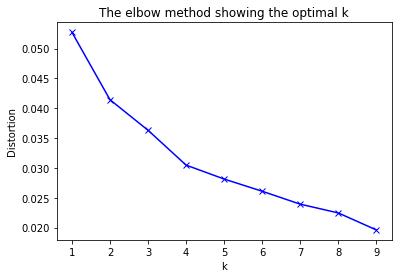

In [10]:
plt.plot()
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The elbow method showing the optimal k')
plt.show()

4 clusters appears to be a reasonable value (although there is no obvious elbow).

In [11]:
kclusters = 4
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(pt_coords)
pt_venues.insert(0, 'Cluster Label', kmeans.labels_)

In [12]:
map_toronto_clusters = folium.Map(location = [toronto_lat, toronto_lon], zoom_start = 11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add marker for each restautant to the map
markers_colors = []
for lat, lon, name, cluster in zip(pt_venues['Venue Lat'], pt_venues['Venue Lon'], pt_venues['Venue Name'], \
                                    pt_venues['Cluster Label']):
    label = folium.Popup('Cluster ' + str(cluster) + ' - ' + str(name), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 7,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.4).add_to(map_toronto_clusters)

In [13]:
map_toronto_clusters

In [14]:
cluster_toronto = pt_venues.drop(['Neighborhoods', 'Venue Lat', 'Venue Lon'], axis = 1)
for i in range(kclusters):
    counts = cluster_toronto[cluster_toronto['Cluster Label'] == i].count()
    print('Cluster %i contains %i Italian restaurants.' % (i, counts[0]))

Cluster 0 contains 219 Italian restaurants.
Cluster 1 contains 44 Italian restaurants.
Cluster 2 contains 63 Italian restaurants.
Cluster 3 contains 24 Italian restaurants.


We can see that Cluster 1 is the largest cluster  

We can also visualize

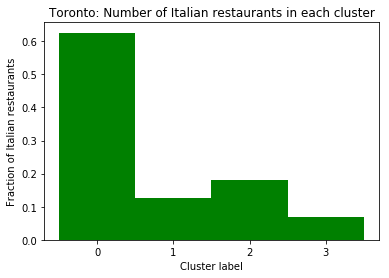

In [15]:
plt.hist(cluster_toronto['Cluster Label'], bins = np.arange(kclusters+0.5), density = True, color = 'g');
plt.xlabel('Cluster label');
plt.title('Toronto: Number of Italian restaurants in each cluster');
plt.xticks([0.5, 1.5, 2.5, 3.5],['0', '1', '2', '3']);
plt.ylabel('Fraction of Italian restaurants');

Print the names of the restaurants in each cluster.

In [16]:
df_grouped = cluster_toronto.groupby('Cluster Label')['Venue Name'].apply(', '.join).reset_index()
for i in range(kclusters):
    print('The following restaurants are in Cluster %i:\n%s\n' % (i, df_grouped['Venue Name'][i]))

The following restaurants are in Cluster 0:
San Francesco, Bravo Pizza, Masellis Supermarket, La Grotta Ristorante & Pizzeria, 7 Numbers, Cafe Fiorentina, Florentina's Italian Restaurant, Pizzeria Libretto, Trapezzi, Il Fornello, Frankie’s Italian, Lil' Baci, Ascari Enoteca, Pizza Nova, The Peasant Table, Baldini, Ascari, Il Ponte Cucina Italiana, Baldini, Gio Rana's Really Really Nice Restaurant, Nove Trattoria, Boccone Deli Cafe & Pizza, Spiga, Capocaccia Café, Divino Restaurant, Leigh's Work, Scaramouche Pasta Bar, Sfizio, Bacaro, Bar Centrale by Terroni, Bacaro, Quanto Basta, Terroni, Caffe Doria, Bacaro Italian Eatery, italian vegatarian  magic, F'Amelia, La locale, Hey Lucy, Olympic 76 Pizza, Brownstone's Bistro & Bar, Dal Moro's Fresh Pasta To Go, Sambucas on Church, Hornero, True Restaurant, 7 West Cafe, Blu Ristorante and Lounge, Scaddabush Italian Kitchen & Bar, Sofia, Focaccia, Cibo Wine Bar, Trattoria Nervosa, Scaccia Restaurant, Shade, Pastacceria, Zaza paninoteca, Caffe d

## Paris

### Data wrangling & setup

- Define the postal codes and neighborhood names.
- Get center coords of each neighborhood using Nominatum
- Get center coords of Paris using Nominatum

Postal codes in Paris are very sensibly defined, so there is no need to scrape the web or parse any html.

- All Paris postal codes begin with 750.
- They end with a two-digit number of the *arrondissement* (neighborhood), from 01 to 20.

In [17]:
l = []
prefix = '750'
for i in range(1,21):
    postal_code = int(prefix + str(i).zfill(2))
    arrondissement = 'Arrondissement ' + str(i)
    address = str(postal_code) + ', France' 
    geolocator = Nominatim(user_agent = 'paris_explorer')
    location = geolocator.geocode(address)
    arrondissement_lat = location.latitude
    arrondissement_lon = location.longitude
    l.append([postal_code, arrondissement, arrondissement_lat, arrondissement_lon])

df = pd.DataFrame(l, columns = ['PostalCode', 'Neighborhood', 'Lat', 'Lon'])

df_postal_code = df[['PostalCode']].copy()

address = 'Paris, France'
geolocator = Nominatim(user_agent = 'paris_explorer')
location = geolocator.geocode(address)
paris_lat = location.latitude
paris_lon = location.longitude
print('The center coordnates of Paris are Latitude {} e Longitude {}.'.format(paris_lat, paris_lon))

print('Found %i postal codes / neighborhoods / arrondissements.' % df.shape[0])
print('\nHere are the first 5 rows of our Paris dataframe:')
df.head()

The center coordnates of Paris are Latitude 48.8566101 e Longitude 2.3514992.
Found 20 postal codes / neighborhoods / arrondissements.

Here are the first 5 rows of our Paris dataframe:


,PostalCode,Neighborhood,Lat,Lon
0,75001,Arrondissement 1,48.857366,2.336815
1,75002,Arrondissement 2,48.867280,2.344442
2,75003,Arrondissement 3,48.862640,2.360379
3,75004,Arrondissement 4,48.855361,2.358386
4,75005,Arrondissement 5,48.850618,2.343946


### Searching for all Italian restaurants in Paris

- Searching each PostalCode (neighborhood) with Foursquare
- Cleaning dataframe (removing duplicated)

In [18]:
pt_venues = SearchNearbyVenues(neighborhoods = df['Neighborhood'], lats = df['Lat'], \
                               lons = df['Lon'], categoryId = pt_restos, radius = 1000, LIMIT = 50)

pt_venues.drop_duplicates('Venue Lat', keep = 'first', inplace = True)
pt_venues.drop(['Neighborhoods Lat', 'Neighborhoods Lon'], axis = 1, inplace = True)
print('\nThere are %i Italian restaurants in Paris.' % int(pt_venues.shape[0]))
print('\nHere are the first 5 rows of our Paris Italian restaurants dataframe:')
pt_venues.head()

Getting results from:
Arrondissement 1 ... Arrondissement 2 ... Arrondissement 3 ... Arrondissement 4 ... Arrondissement 5 ... Arrondissement 6 ... Arrondissement 7 ... Arrondissement 8 ... Arrondissement 9 ... Arrondissement 10 ... Arrondissement 11 ... Arrondissement 12 ... Arrondissement 13 ... Arrondissement 14 ... Arrondissement 15 ... Arrondissement 16 ... Arrondissement 17 ... Arrondissement 18 ... Arrondissement 19 ... Arrondissement 20 ... DONE.

There are 515 Italian restaurants in Paris.

Here are the first 5 rows of our Paris Italian restaurants dataframe:


,Neighborhoods,Venue Name,Venue Lat,Venue Lon
0,Arrondissement 1,Il Vicolo,48.855865,2.337562
1,Arrondissement 1,cinquecento,48.860434,2.348277
2,Arrondissement 1,Marcello,48.852340,2.335242
3,Arrondissement 1,Gemini Les Halles,48.859892,2.346626
4,Arrondissement 1,Il Suppli,48.851767,2.338393


### Visualizing Paris Italian restaurants

- Using Folium markers with popups

In [19]:
map_paris = folium.Map(location = [paris_lat, paris_lon], zoom_start = 12, width = '100%', height = '70%')

for venue, lat, lon in zip(pt_venues['Venue Name'], pt_venues['Venue Lat'], pt_venues['Venue Lon']):
    label = folium.Popup(venue, parse_html = True)
    folium.CircleMarker([lat, lon], popup = label, radius = 5, color = 'green', fill = True, fill_color = 'red', fill_opacity = 0.3, \
                        parse_html = False).add_to(map_paris)  

map_paris

### Clustering Italian restaurants in Paris

- Using KMeans clustering algorithm & elbow method
- Visualization
- Some analysis

In [20]:
pt_coords = pt_venues.drop(['Venue Name', 'Neighborhoods'], axis = 1)

distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(pt_coords)
    distortions.append(sum(np.min(cdist(pt_coords, kmeans.cluster_centers_, 'euclidean'), axis = 1)) / pt_coords.shape[0])

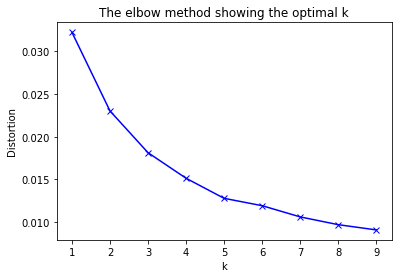

In [21]:
plt.plot()
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The elbow method showing the optimal k')
plt.show()

5 clusters seems an okay choice (although there is no clear elbow).

In [22]:
kclusters = 5
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(pt_coords)
pt_venues.insert(0, 'Cluster Label', kmeans.labels_)

In [23]:
map_paris_clusters = folium.Map(location = [paris_lat, paris_lon], zoom_start = 12)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add marker for each restaurant to the map
markers_colors = []
for lat, lon, name, cluster in zip(pt_venues['Venue Lat'], pt_venues['Venue Lon'], pt_venues['Venue Name'], \
                                    pt_venues['Cluster Label']):
    label = folium.Popup('Cluster ' + str(cluster) + ' - ' + str(name), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 7,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.4).add_to(map_paris_clusters)

In [24]:
map_paris_clusters

Let's see how many restaurants are in each cluster.

In [25]:
cluster_paris = pt_venues.drop(['Neighborhoods', 'Venue Lat', 'Venue Lon'], axis = 1)
for i in range(kclusters):
    counts = cluster_paris[cluster_paris['Cluster Label'] == i].count()
    print('Cluster %i contains %i Italian restaurants.' % (i, counts[0]))

Cluster 0 contains 86 Italian restaurants.
Cluster 1 contains 115 Italian restaurants.
Cluster 2 contains 151 Italian restaurants.
Cluster 3 contains 42 Italian restaurants.
Cluster 4 contains 121 Italian restaurants.


We can see that Cluster 0 is the largest cluster  

We can also visualize this

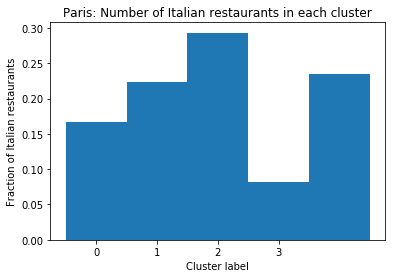

In [26]:
plt.hist(cluster_paris['Cluster Label'], bins = np.arange(kclusters+0.5), density = True);
plt.xlabel('Cluster label');
plt.title('Paris: Number of Italian restaurants in each cluster');
plt.xticks([0.5, 1.5, 2.5, 3.5],['0', '1', '2', '3']);
plt.ylabel('Fraction of Italian restaurants');

And we can get a printout of the names of the restaurants in each cluster.

In [27]:
df_grouped = cluster_paris.groupby('Cluster Label')['Venue Name'].apply(', '.join).reset_index()
for i in range(kclusters):
    print('The following restaurants are in Cluster %i:\n%s\n' % (i, df_grouped['Venue Name'][i]))

The following restaurants are in Cluster 0:
Finzi, Allegria, Bistrot Napolitain, La Vinoteca, Il Conte, Le Carpaccio, La Cantina Chic, Blue Pasta, Maitre Pierre, Topolino, Made In Italy, Gran Caffé Convivium, Café de New York, Le bigado, Goût-Thé, Inte Caffe, César, Vapiano, Domani, Il Carpaccio - Le Royal Monceau, Casa Di Delfo, Guido de Luca, Pizza Trionfo, Le Balzac, Fenice, Café di Roma, Il Gusto Sardo, Cafe Michelangelo, Prego's, Trapani, Samesa, La Donna Restaurant Italien, Penati al Baretto, Goû-thé, Chez Oggi, Pasta e Basta, Caffe' Italiano, In té caffe, Fiat Caffé, Casa Luca, NoLita, Le Petit Augustin, Ziti, Restaurant Pietro, Il Caffé, Mozzachic, Villa Sophia, Cantina Di Luca, Le Stresa, Bistro Romain, Little Nonna, La Fabbrica, Le Comptoir d'Alphonse, Zino, La Famiglia, Le Rital, Lino Ristorante, Da Franco, Sormani, O Gusto, Mr & Miss Bond, I Ghiotti, Bistro d'Italie, La Rosa, Villa Cesar, Fame Da Lupo, Il Ristorante, Il Grano, Le Talon Caché, Romantica Caffé, Sale e Pepe, L

## Conclusions

* There are more Italian restaurants in Paris than in Toronto:  
 * There are 350 Italian restaurants in Toronto
 * There are 515 Italian restaurants in Paris   
  
* Source: Wikipedia
 * This difference is not because of a difference in population (Toronto has a population of 2.7 million vs. Paris with 2.1 million)
 * Toronto proper is significantly larger in area (630 sq km) than Paris (105 sq. km)  
 
* We conclude that Paris is more densely populated with Italian restaurants, but they are arranged in a larger number of clusters than in Toronto. This is likely because there is no historic Italian neighborhood in Paris proper